In [1]:
spark

In [19]:
# %%writefile ../training.py
from pyspark.ml.classification import LogisticRegression
from pyspark import SparkConf
from pyspark.sql import SparkSession

import logging
import urllib.request

logging.getLogger("py4j").setLevel(logging.ERROR)

# spark name and other properties are set by the framework launcher in spark-submit. don't override
spark = SparkSession.builder \
    .config(conf=SparkConf()) \
    .getOrCreate()


def train(spark, data_conf, model_conf, **kwargs):
    hyperparams = model_conf["hyperParameters"]

    # for this demo we're downloading the dataset locally and then reading it. This is obviously not production setting
    # https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt
    urllib.request.urlretrieve(data_conf["url"], "/tmp/data.txt")

    training = spark.read.format("libsvm").load("/tmp/data.txt")

    lr = LogisticRegression(maxIter=hyperparams["maxIter"],
                            regParam=hyperparams["regParam"],
                            elasticNetParam=hyperparams["elasticNetParam"])

    print("Starting training...")

    lr_model = lr.fit(training)

    # Print the coefficients and intercept for logistic regression
    print("Coefficients: {}".format(str(lr_model.coefficients)))
    print("Intercept: {}".format(str(lr_model.intercept)))

    print("Finished training")

    # export model artefacts to models/ folder

    print("Saved trained model")
    lr_model.write().overwrite() \
        .save(data_conf["model_path"])

    return lr_model

In [20]:
import json

model_conf = json.load(open("../config.json", "r"))
data_conf = {
    "url": "https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt",
    "test_split": 0.2,
    "model_path": "file:///tmp/lr"
}

lr_model = train(spark, data_conf, model_conf)

Starting training...
Coefficients: (692,[244,263,272,300,301,328,350,351,378,379,405,406,407,428,433,434,455,456,461,462,483,484,489,490,496,511,512,517,539,540,568],[-7.353983524188197e-05,-9.102738505589466e-05,-0.00019467430546904298,-0.00020300642473486668,-3.1476183314863995e-05,-6.842977602660743e-05,1.5883626898239883e-05,1.4023497091372047e-05,0.00035432047524968605,0.00011443272898171087,0.00010016712383666666,0.0006014109303795481,0.0002840248179122762,-0.00011541084736508837,0.000385996886312906,0.000635019557424107,-0.00011506412384575676,-0.00015271865864986808,0.0002804933808994214,0.0006070117471191634,-0.0002008459663247437,-0.0001421075579290126,0.0002739010341160883,0.00027730456244968115,-9.838027027269332e-05,-0.0003808522443517704,-0.00025315198008555033,0.00027747714770754307,-0.0002443619763919199,-0.0015394744687597765,-0.00023073328411331293])
Intercept: 0.22456315961250325
Finished training
Saved trained model


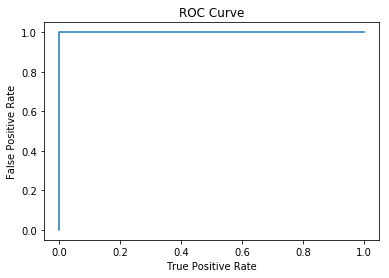

Training set areaUnderROC: 1.0


In [7]:
import matplotlib.pyplot as plt

summary = lr_model.summary
roc = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(summary.areaUnderROC))

In [9]:
from pyspark.ml.classification import LogisticRegressionModel
lr_model = LogisticRegressionModel.load("file:///tmp/lr")

test = spark.read.format("libsvm").load("/tmp/data.txt")
predictions = lr_model.transform(test)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(692,[127,128,129...|[0.73765439548910...|[0.67648272431605...|       0.0|
|  1.0|(692,[158,159,160...|[-1.2286964884747...|[0.22640965216205...|       1.0|
|  1.0|(692,[124,125,126...|[-1.2596645795726...|[0.22103163838284...|       1.0|
|  1.0|(692,[152,153,154...|[-1.0845333752697...|[0.25264907653471...|       1.0|
|  1.0|(692,[151,152,153...|[-1.2371063245185...|[0.22494007343582...|       1.0|
|  0.0|(692,[129,130,131...|[0.73839617859787...|[0.67664504514663...|       0.0|
|  1.0|(692,[158,159,160...|[-1.2123284339889...|[0.22928932070495...|       1.0|
|  1.0|(692,[99,100,101,...|[-0.2350856805053...|[0.44149776057216...|       1.0|
|  0.0|(692,[154,155,156...|[0.10357406008713...|[0.52587039191803...|       0.0|
|  0.0|(692,[127

In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [17]:
# %%writefile ../scoring.py
import json
import logging
import urllib.request

from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import SparkConf
from pyspark.sql import SparkSession

logging.getLogger("py4j").setLevel(logging.ERROR)

# spark name and other properties are set by the framework launcher in spark-submit. don't override
spark = SparkSession.builder \
    .config(conf=SparkConf()) \
    .getOrCreate()


def evaluate(spark, data_conf, model_conf, **kwargs):
    lr_model = LogisticRegressionModel.load(data_conf["model_path"])

    # for this demo we're downloading the dataset locally and then reading it. This is obviously not production setting
    # https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt
    urllib.request.urlretrieve(data_conf["url"], "/tmp/data.txt")

    test = spark.read.format("libsvm").load("/tmp/data.txt")

    predictions = lr_model.transform(test)

    evaluator = BinaryClassificationEvaluator()
    roc = evaluator.evaluate(predictions)
    print('Test Area Under ROC: {}'.format(roc))

    with open("models/evaluation.json", "w+") as f:
        json.dump({'roc': roc}, f)


In [18]:
evaluate(spark, data_conf, model_conf)

Test Area Under ROC: 1.0
